In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_curve, auc
from scipy.stats import wilcoxon
import requests
from sklearn.datasets import fetch_openml, make_classification
import io
import os
import warnings

# Configuración visual
sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')



In [ ]:
# Evitar warnings molestos de versiones
warnings.filterwarnings('ignore')

def procesar_y_exportar_vertebral():
    print("PROCESANDO TU DATASET (Vertebral Column)...")
    
    X, y = None, None
    
    # 1. INTENTO DE DESCARGA VÍA OPENML (Más robusto que URL directa)
    try:
        print("Descargando desde OpenML (ID: 1523)...")
        # ID 1523 corresponde a "vertebral-column-2clases" de la UCI
        dataset = fetch_openml(data_id=1523, as_frame=True, parser='auto')
        
        X_raw = dataset.data
        y_raw = dataset.target
        
        # Convertir a numpy si es DataFrame
        if isinstance(X_raw, pd.DataFrame):
            X = X_raw.values
            column_names = X_raw.columns.tolist()
        else:
            X = X_raw
            column_names = [f'feat_{i}' for i in range(X.shape[1])]
            
        # Convertir target a numpy y asegurar formato
        if isinstance(y_raw, pd.Series):
            y_raw = y_raw.values
            
        # Codificar target (AB/NO -> 1/0)
        le = LabelEncoder()
        y = le.fit_transform(y_raw)
        
        print(f"Descarga exitosa: {X.shape[0]} filas, {X.shape[1]} columnas.")
        
    except Exception as e:
        print(f"   ⚠️ Falló OpenML: {e}")

    # 3. PROCESAMIENTO Y EXPORTACIÓN
    try:
        # Estandarizar (OBLIGATORIO)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # --- A) GUARDAR ORIGINAL ---
        df_orig = pd.DataFrame(X_scaled, columns=column_names)
        df_orig['target'] = y
        df_orig.to_csv('dataset_vertebral_original.csv', index=False)
        print("Guardado: dataset_vertebral_original.csv")
        
        # --- B) GUARDAR PCA (60% Varianza) ---
        pca = PCA(n_components=0.60, random_state=42)
        X_pca = pca.fit_transform(X_scaled)
        
        cols_pca = [f'PC{i+1}' for i in range(X_pca.shape[1])]
        df_pca = pd.DataFrame(X_pca, columns=cols_pca)
        df_pca['target'] = y
        df_pca.to_csv('dataset_vertebral_pca.csv', index=False)
        print(f"Guardado: dataset_vertebral_pca.csv ({X_pca.shape[1]} componentes)")
        
        # --- C) GUARDAR AUTOENCODER (Mitad de features) ---
        n_inputs = X_scaled.shape[1]
        n_hidden = max(1, int(n_inputs / 2))
        
        # Entrenamos el Autoencoder
        ae = MLPRegressor(hidden_layer_sizes=(n_hidden,), activation='relu', max_iter=1000, random_state=42)
        ae.fit(X_scaled, X_scaled)
        
        # Extraemos la capa oculta
        W = ae.coefs_[0]
        b = ae.intercepts_[0]
        X_ae = np.maximum(0, np.dot(X_scaled, W) + b)
        
        cols_ae = [f'AE{i+1}' for i in range(X_ae.shape[1])]
        df_ae = pd.DataFrame(X_ae, columns=cols_ae)
        df_ae['target'] = y
        df_ae.to_csv('dataset_vertebral_autoencoder.csv', index=False)
        print(f"Guardado: dataset_vertebral_autoencoder.csv ({X_ae.shape[1]} neuronas)")
        
        print("LISTO! Archivos CSV generados correctamente.")
        
    except Exception as e:
        print(f"Error crítico procesando datos: {e}")

# Ejecutar
procesar_y_exportar_vertebral()

PROCESANDO TU DATASET (Vertebral Column)...
Descargando desde OpenML (ID: 1523)...
   ✅ Descarga exitosa: 310 filas, 6 columnas.
Guardado: dataset_vertebral_original.csv
Guardado: dataset_vertebral_pca.csv (2 componentes)
Guardado: dataset_vertebral_autoencoder.csv (3 neuronas)
LISTO! Archivos CSV generados correctamente.


In [ ]:
# Configuración
nombres_datasets = ['vertebral', 'alex', 'mauro', 'jordi', 'elena'] 
tipos_archivos = ['original', 'pca', 'autoencoder']

knn = KNeighborsClassifier()
mlp = MLPClassifier(max_iter=1000, random_state=42)
param_grid_knn = {'n_neighbors': [3, 5, 7]}
param_grid_mlp = {'hidden_layer_sizes': [(50,), (100,)], 'activation': ['relu', 'tanh'], 'learning_rate_init': [0.001]}

results_list = []
roc_data = {'y_true': [], 'probas': {'Original-MLP': [], 'PCA-MLP': [], 'AE-MLP': []}}

print(f"INICIANDO ANÁLISIS DE {len(nombres_datasets)} CONJUNTOS DE DATOS...")

for nombre in nombres_datasets:
    print(f"\nAnalizando conjunto: {nombre}")
    save_roc = (nombre == 'vertebral') # Solo guardamos ROC del tuyo
    
    for tipo in tipos_archivos:
        archivo = f"dataset_{nombre}_{tipo}.csv"
        
        try:
            # 1. CARGAR
            df = pd.read_csv(archivo)
            
            # Separar X e y
            if 'target' in df.columns:
                y = df['target'].values
                X = df.drop(columns=['target']).values
            else:
                y = df.iloc[:, -1].values
                X = df.iloc[:, :-1].values

            # --- CORRECCIÓN AUTOMÁTICA DE ETIQUETAS ---
            # Esto arregla el error "ValueError: multiclass format"
            le = LabelEncoder()
            y = le.fit_transform(y)
            # -------------------------------------------

            # 2. CROSS-VALIDATION
            cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
            fold_idx = 0
            
            for train_ix, test_ix in cv.split(X, y):
                fold_idx += 1
                X_train, X_test = X[train_ix], X[test_ix]
                y_train, y_test = y[train_ix], y[test_ix]
                
                # Guardar y_true para ROC (una sola vez por dataset)
                if save_roc and tipo == 'original':
                    roc_data['y_true'].append(y_test)

                # kNN
                g_knn = GridSearchCV(knn, param_grid_knn, cv=3, n_jobs=-1).fit(X_train, y_train)
                
                # Nombre bonito para el gráfico
                if tipo == 'original': t_name = 'Original'
                elif tipo == 'pca': t_name = 'PCA'
                else: t_name = 'Autoencoder'
                
                results_list.append({'Dataset': nombre, 'Fold': fold_idx, 'Type': t_name, 'Model': 'kNN', 'Accuracy': g_knn.score(X_test, y_test)})
                
                # MLP
                g_mlp = GridSearchCV(mlp, param_grid_mlp, cv=3, n_jobs=-1).fit(X_train, y_train)
                results_list.append({'Dataset': nombre, 'Fold': fold_idx, 'Type': t_name, 'Model': 'MLP', 'Accuracy': g_mlp.score(X_test, y_test)})
                
                # Guardar datos ROC
                if save_roc:
                    key = f"{t_name}-MLP"
                    if key in roc_data['probas']:
                        roc_data['probas'][key].append(g_mlp.predict_proba(X_test))

            print(f"   -> {tipo.upper()}: OK")
            
        except FileNotFoundError:
            print(f"Falta archivo: {archivo} (Ignorando...)")
        except Exception as e:
            print(f"Error en {archivo}: {e}")

df_results = pd.DataFrame(results_list)
print("\nANÁLISIS COMPLETADO. Ejecuta ahora la celda de gráficos.")

INICIANDO ANÁLISIS DE 5 CONJUNTOS DE DATOS...

Analizando conjunto: vertebral
   -> ORIGINAL: OK
   -> PCA: OK
   -> AUTOENCODER: OK

Analizando conjunto: alex
   -> ORIGINAL: OK
   -> PCA: OK
   -> AUTOENCODER: OK

Analizando conjunto: mauro
   -> ORIGINAL: OK
   -> PCA: OK
   -> AUTOENCODER: OK

Analizando conjunto: jordi
   -> ORIGINAL: OK
   -> PCA: OK
   -> AUTOENCODER: OK

Analizando conjunto: elena
   -> ORIGINAL: OK
   -> PCA: OK
   -> AUTOENCODER: OK

ANÁLISIS COMPLETADO. Ejecuta ahora la celda de gráficos.


GENERANDO GRÁFICOS...


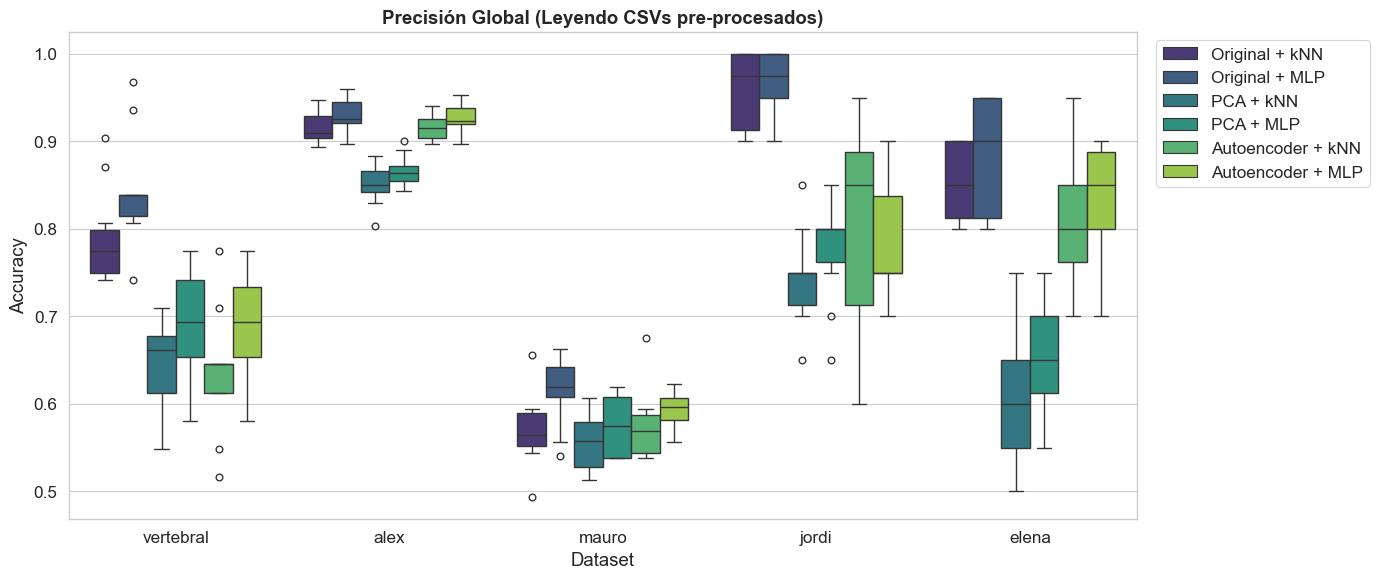

   -> Calculando Estadísticas...


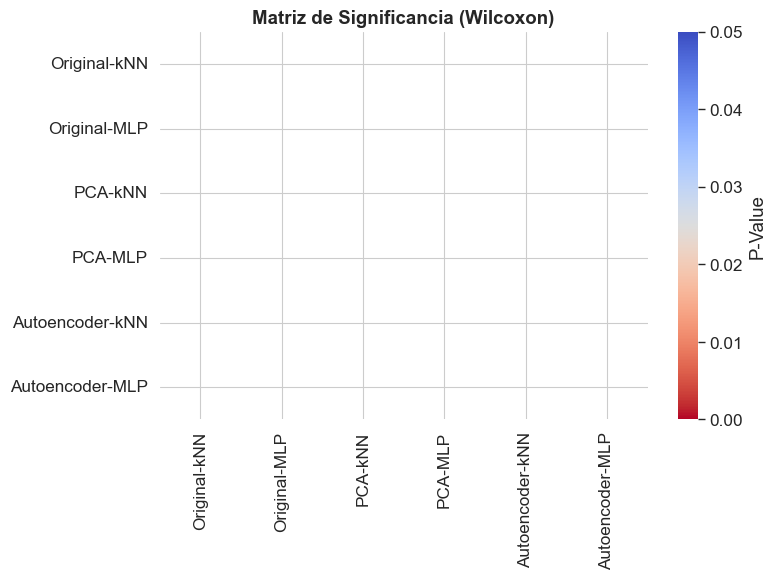

   -> Generando ROC...


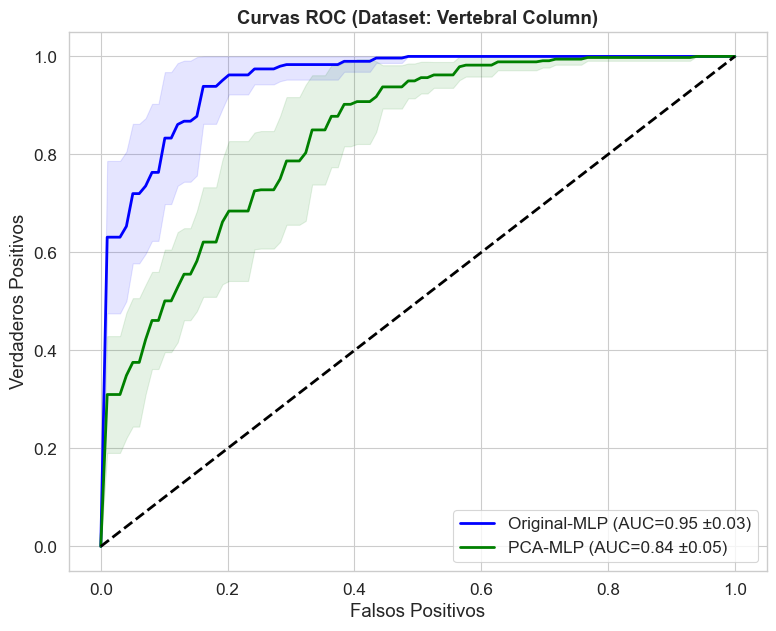

In [15]:
# --- GENERACIÓN DE GRÁFICOS ---
if not df_results.empty:
    print("GENERANDO GRÁFICOS...")

    # 1. Boxplot
    plt.figure(figsize=(14, 6))
    df_results['Config'] = df_results['Type'] + " + " + df_results['Model']
    sns.boxplot(x='Dataset', y='Accuracy', hue='Config', data=df_results, palette='viridis')
    plt.title('Precisión Global (Leyendo CSVs pre-procesados)', fontweight='bold')
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('accuracy_boxplot.png', dpi=300)
    plt.show()

    # 2. Heatmap
    print("   -> Calculando Estadísticas...")
    df_results['Strategy'] = df_results['Type'] + "-" + df_results['Model']
    strategies = df_results['Strategy'].unique()
    p_vals = np.zeros((len(strategies), len(strategies)))

    for i, s1 in enumerate(strategies):
        for j, s2 in enumerate(strategies):
            if i >= j: 
                p_vals[i,j] = np.nan; continue
            d1 = df_results[df_results['Strategy'] == s1].groupby(['Dataset','Fold'])['Accuracy'].mean()
            d2 = df_results[df_results['Strategy'] == s2].groupby(['Dataset','Fold'])['Accuracy'].mean()
            try:
                stat, p = wilcoxon(d1, d2)
                p_vals[i,j] = p; p_vals[j,i] = p
            except: p_vals[i,j] = 1.0

    plt.figure(figsize=(8, 6))
    mask = np.triu(np.ones_like(p_vals, dtype=bool))
    sns.heatmap(p_vals, xticklabels=strategies, yticklabels=strategies, annot=True, fmt=".3f", 
                cmap="coolwarm_r", mask=mask, vmin=0, vmax=0.05, cbar_kws={'label': 'P-Value'})
    plt.title('Matriz de Significancia (Wilcoxon)', fontweight='bold')
    plt.tight_layout()
    plt.savefig('wilcoxon_heatmap.png', dpi=300)
    plt.show()

    # 3. ROC (Vertebral Column)
    if len(roc_data['probas']['Original-MLP']) > 0:
        print("   -> Generando ROC...")
        from sklearn.preprocessing import label_binarize
        plt.figure(figsize=(9, 7))
        mean_fpr = np.linspace(0, 1, 100)
        colors = {'Original-MLP': 'blue', 'PCA-MLP': 'green', 'AE-MLP': 'red', 'Autoencoder-MLP': 'red'}

        for label, probas in roc_data['probas'].items():
            if len(probas) == 0:
                continue

            # collect interpolated TPRs and AUCs per fold (handling binary or multiclass)
            tprs_folds = []
            aucs_folds = []

            for yt, yp in zip(roc_data['y_true'], probas):
                # If predictions are 1D scores or single-prob column, treat as binary
                if yp.ndim == 1 or (yp.ndim == 2 and yp.shape[1] == 1):
                    preds = yp.ravel()
                    # require both classes present in yt
                    if len(np.unique(yt)) < 2:
                        continue
                    fpr, tpr, _ = roc_curve(yt, preds)
                    interp_tpr = np.interp(mean_fpr, fpr, tpr)
                    interp_tpr[0] = 0.0
                    tprs_folds.append(interp_tpr)
                    aucs_folds.append(auc(fpr, tpr))
                else:
                    # Multiclass case: binarize and average one-vs-rest across classes for this fold
                    classes = np.unique(yt)
                    Yb = label_binarize(yt, classes=classes)
                    n_c = Yb.shape[1]
                    tprs_per_class = []
                    aucs_per_class = []
                    for c in range(n_c):
                        y_true_c = Yb[:, c]
                        # choose corresponding score column; if shapes mismatch, skip class
                        if yp.shape[1] < n_c:
                            continue
                        y_score_c = yp[:, c]
                        # need positive and negative samples
                        if y_true_c.sum() == 0 or y_true_c.sum() == len(y_true_c):
                            continue
                        fpr, tpr, _ = roc_curve(y_true_c, y_score_c)
                        interp_tpr = np.interp(mean_fpr, fpr, tpr)
                        interp_tpr[0] = 0.0
                        tprs_per_class.append(interp_tpr)
                        aucs_per_class.append(auc(fpr, tpr))
                    if len(tprs_per_class) == 0:
                        continue
                    # average over classes for this fold
                    tprs_folds.append(np.mean(tprs_per_class, axis=0))
                    aucs_folds.append(np.mean(aucs_per_class))

            if len(tprs_folds) == 0:
                continue

            mean_tpr = np.mean(tprs_folds, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = auc(mean_fpr, mean_tpr)
            std_auc = np.std(aucs_folds) if len(aucs_folds) > 0 else 0.0

            plt.plot(mean_fpr, mean_tpr, color=colors.get(label, 'black'), lw=2,
                     label=f'{label} (AUC={mean_auc:0.2f} ±{std_auc:0.2f})')
            std_tpr = np.std(tprs_folds, axis=0)
            tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
            plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors.get(label, 'black'), alpha=.1)

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlabel('Falsos Positivos')
        plt.ylabel('Verdaderos Positivos')
        plt.title('Curvas ROC (Dataset: Vertebral Column)', fontweight='bold')
        plt.legend(loc="lower right")
        plt.savefig('scientific_roc.png', dpi=300)
        plt.show()
else:
    print("No hay resultados para graficar.")